<a href="https://colab.research.google.com/github/NiyonshutiDavid/Hidden-Markov-Models/blob/main/HMM_Formative2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition using HMM

Using smartphone sensors to classify four activities: standing, walking, jumping, still.
Implementing HMM for sequence modeling and prediction.
Data collected at 100 Hz sampling rate.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)



## Data Loading

Load sensor data from activity folders and organize by activity type.

In [26]:
data_path = Path('/content/Hidden-Markov-Models/data/Raw Data')
activity_folders = sorted(data_path.glob('*'))

activity_samples = defaultdict(list)
activity_counts = defaultdict(int)

for folder in activity_folders:
    activity = folder.name.split('_')[0].lower()
    activity_samples[activity].append(folder)
    activity_counts[activity] += 1

for activity, count in sorted(activity_counts.items()):
    print(f"{activity.capitalize()}: {count} samples")

activity_names = sorted(activity_counts.keys())



Jumping: 13 samples
Standing: 13 samples
Still: 12 samples
Walking: 12 samples


In [27]:
def load_sample_data(folder_path):
    accel_file = folder_path / 'AccelerometerUncalibrated.csv'
    gyro_file = folder_path / 'GyroscopeUncalibrated.csv'
    metadata_file = folder_path / 'Metadata.csv'

    accel_df = pd.read_csv(accel_file)
    gyro_df = pd.read_csv(gyro_file)
    metadata = pd.read_csv(metadata_file)

    return accel_df, gyro_df, metadata



In [28]:
data_info = []
for folder in activity_folders:
    activity = folder.name.split('_')[0].lower()
    try:
        accel_df, gyro_df, metadata = load_sample_data(folder)

        data_info.append({
            'folder': folder.name,
            'activity': activity,
            'accel_samples': len(accel_df),
            'gyro_samples': len(gyro_df),
            'duration': accel_df['seconds_elapsed'].max(),
            'device': metadata['device name'].iloc[0],
            'sample_rate': metadata['sampleRateMs'].iloc[0]
        })
    except Exception as e:
        print(f"Error loading {folder.name}: {e}")

data_info_df = pd.DataFrame(data_info)
print(data_info_df.groupby('activity')['duration'].describe())



          count      mean       std       min       25%        50%        75%  \
activity                                                                        
jumping    13.0  9.563595  1.406867  6.074771  9.534476   9.797572  10.330507   
standing   13.0  9.733687  1.604142  5.772181  9.456900  10.053294  10.659558   
still      12.0  9.471811  2.072805  5.570424  8.112296   9.975962  11.055733   
walking    12.0  9.413932  1.701869  5.944133  8.540729  10.026897  10.837496   

                max  
activity             
jumping   11.256380  
standing  11.919560  
still     12.016399  
walking   10.974829  


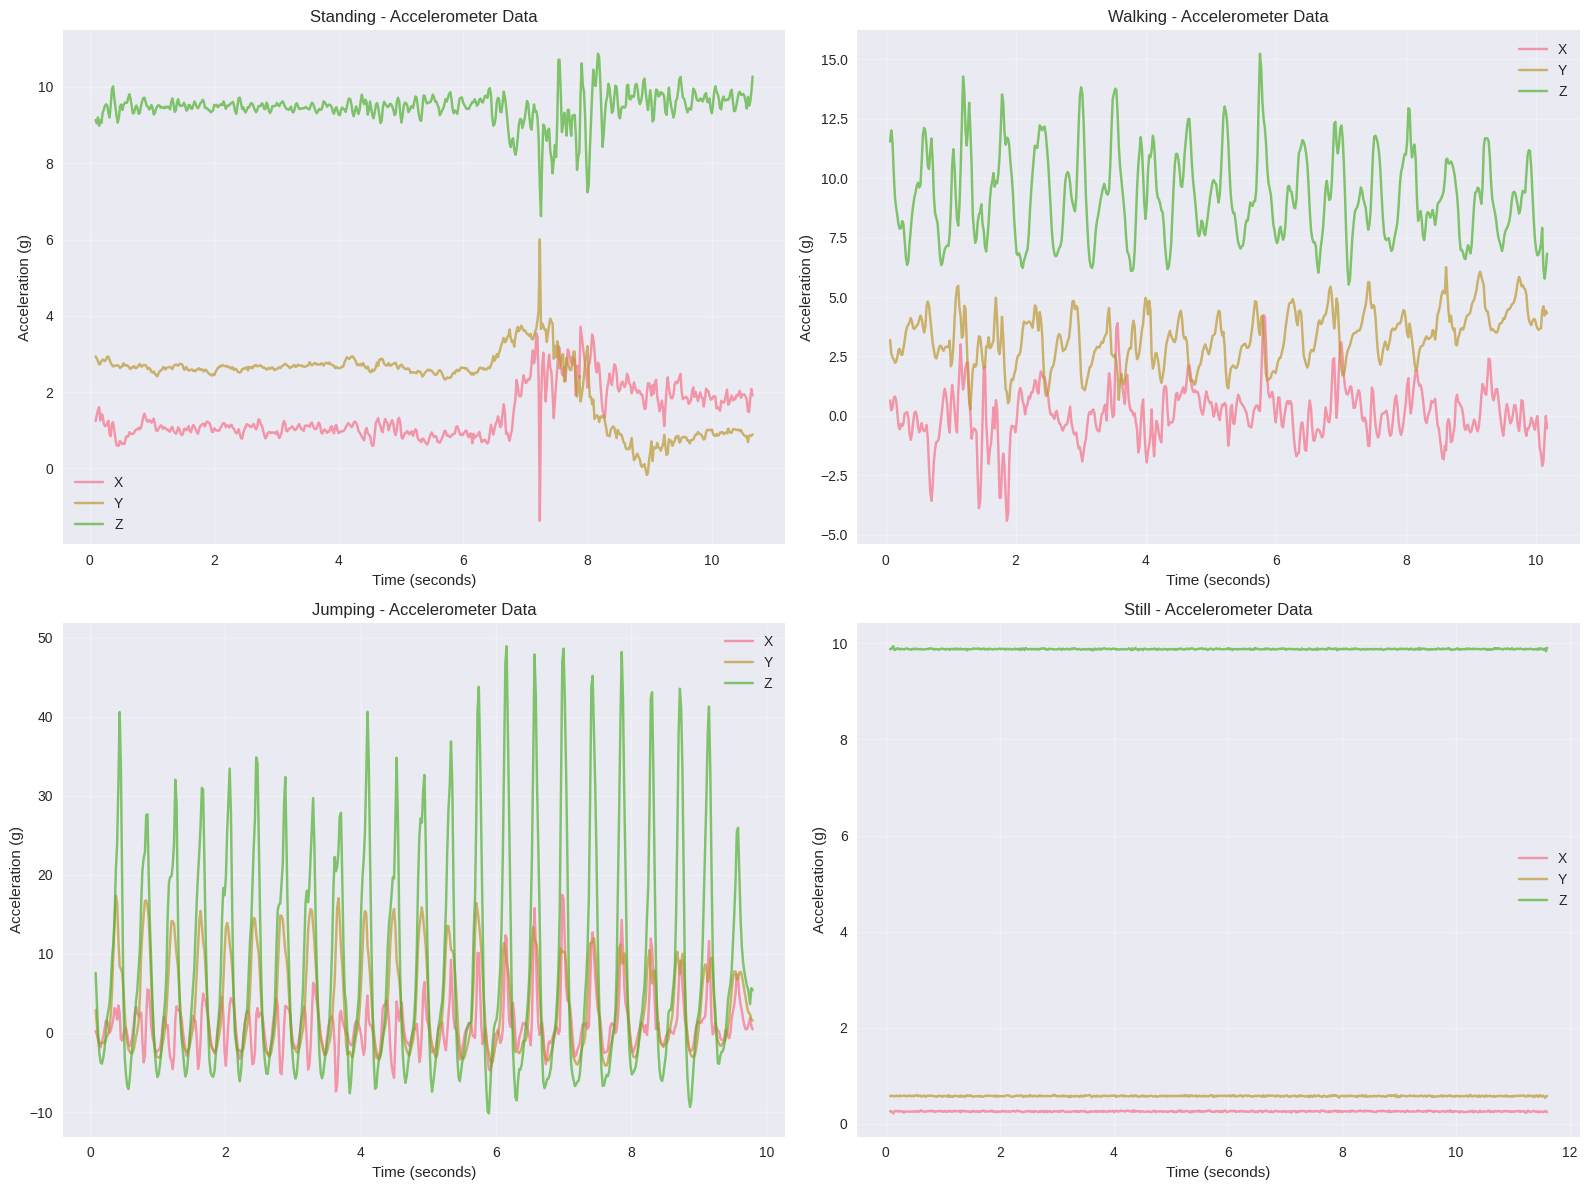

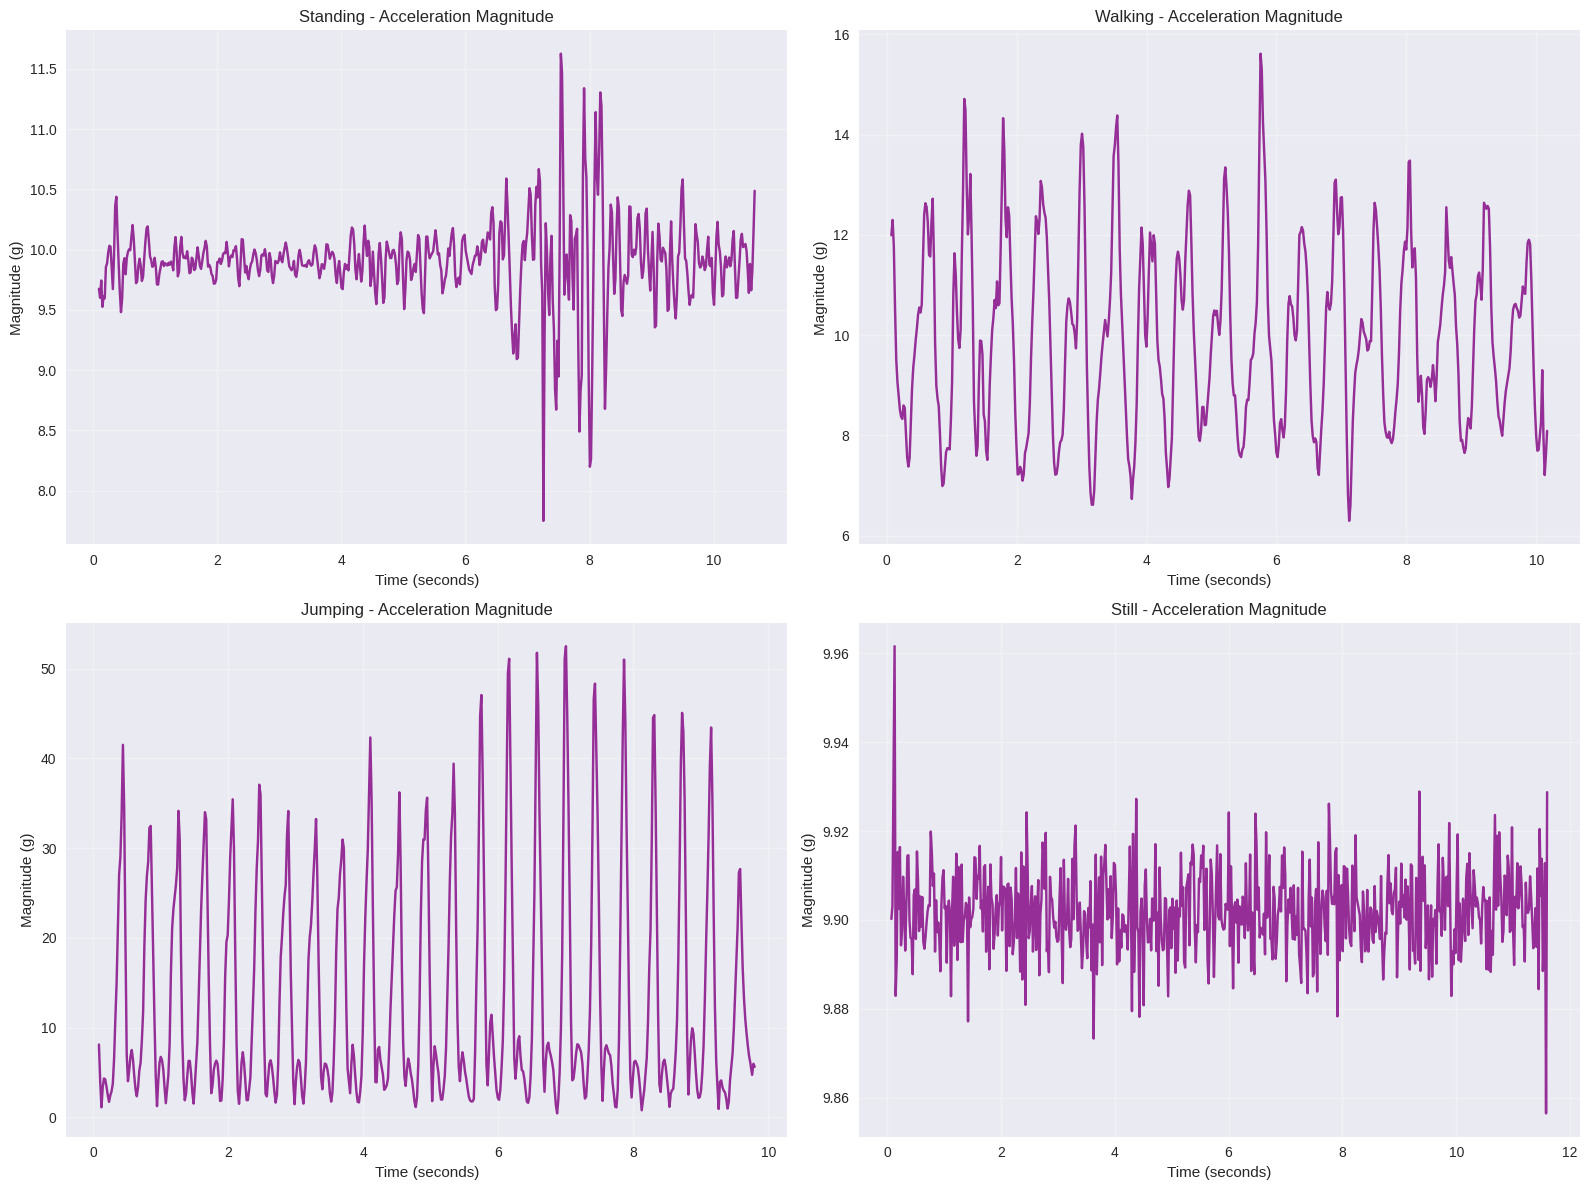

In [55]:
activities_to_plot = ['standing', 'walking', 'jumping', 'still']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, activity in enumerate(activities_to_plot):
    if activity in activity_samples and len(activity_samples[activity]) > 0:
        sample_folder = activity_samples[activity][0]
        accel_df, _, _ = load_sample_data(sample_folder)

        axes[idx].plot(accel_df['seconds_elapsed'], accel_df['x'], label='X', alpha=0.7)
        axes[idx].plot(accel_df['seconds_elapsed'], accel_df['y'], label='Y', alpha=0.7)
        axes[idx].plot(accel_df['seconds_elapsed'], accel_df['z'], label='Z', alpha=0.7)

        axes[idx].set_title(f'{activity.capitalize()} - Accelerometer Data')
        axes[idx].set_xlabel('Time (seconds)')
        axes[idx].set_ylabel('Acceleration (g)')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('accelerometer_data_plots.png')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, activity in enumerate(activities_to_plot):
    if activity in activity_samples and len(activity_samples[activity]) > 0:
        sample_folder = activity_samples[activity][0]
        accel_df, _, _ = load_sample_data(sample_folder)

        magnitude = np.sqrt(accel_df['x']**2 + accel_df['y']**2 + accel_df['z']**2)

        axes[idx].plot(accel_df['seconds_elapsed'], magnitude, color='purple', alpha=0.8)

        axes[idx].set_title(f'{activity.capitalize()} - Acceleration Magnitude')
        axes[idx].set_xlabel('Time (seconds)')
        axes[idx].set_ylabel('Magnitude (g)')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('acceleration_magnitude_plots.png')
plt.show()

## Feature Extraction

Extract time and frequency domain features from 1.5-second windows with 50% overlap.
Normalize features using StandardScaler.

In [30]:
def extract_features(accel_df, gyro_df, window_size=150):
    features_list = []
    total_samples = min(len(accel_df), len(gyro_df))

    for i in range(0, total_samples - window_size, window_size // 2):
        window_features = {}
        accel_window = accel_df.iloc[i:i+window_size]
        gyro_window = gyro_df.iloc[i:i+window_size]

        for axis in ['x', 'y', 'z']:
            window_features[f'accel_mean_{axis}'] = accel_window[axis].mean()
            window_features[f'accel_var_{axis}'] = accel_window[axis].var()
            window_features[f'accel_rms_{axis}'] = np.sqrt(np.mean(accel_window[axis]**2))

            window_features[f'gyro_mean_{axis}'] = gyro_window[axis].mean()
            window_features[f'gyro_var_{axis}'] = gyro_window[axis].var()
            window_features[f'gyro_rms_{axis}'] = np.sqrt(np.mean(gyro_window[axis]**2))

        window_features['accel_sma'] = np.mean(np.abs(accel_window[['x','y','z']])).sum()
        window_features['gyro_sma'] = np.mean(np.abs(gyro_window[['x','y','z']])).sum()

        fs = 100
        fft_accel_x = np.abs(fft(accel_window['x']))
        fft_freq = fftfreq(len(accel_window['x']), 1/fs)
        window_features['accel_dominant_freq'] = fft_freq[np.argmax(fft_accel_x[1:]) + 1]
        window_features['accel_spectral_energy'] = np.sum(fft_accel_x**2)

        fft_gyro_x = np.abs(fft(gyro_window['x']))
        window_features['gyro_dominant_freq'] = fft_freq[np.argmax(fft_gyro_x[1:]) + 1]
        window_features['gyro_spectral_energy'] = np.sum(fft_gyro_x**2)

        features_list.append(window_features)

    return features_list



In [31]:
all_features = []
all_activities = []

for folder in activity_folders:
    activity = folder.name.split('_')[0].lower()
    try:
        accel_df, gyro_df, _ = load_sample_data(folder)
        features = extract_features(accel_df, gyro_df)

        for feat in features:
            feat['activity'] = activity
            all_features.append(feat)
            all_activities.append(activity)
    except Exception as e:
        print(f"Error processing {folder.name}: {e}")

features_df = pd.DataFrame(all_features)
print(f"Total windows: {len(features_df)}")
print(f"Features: {len(features_df.columns) - 1}")



Total windows: 398
Features: 24


In [32]:
feature_columns = [col for col in features_df.columns if col != 'activity']
X = features_df[feature_columns]
y = features_df['activity']

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized_df = pd.DataFrame(X_normalized, columns=feature_columns)



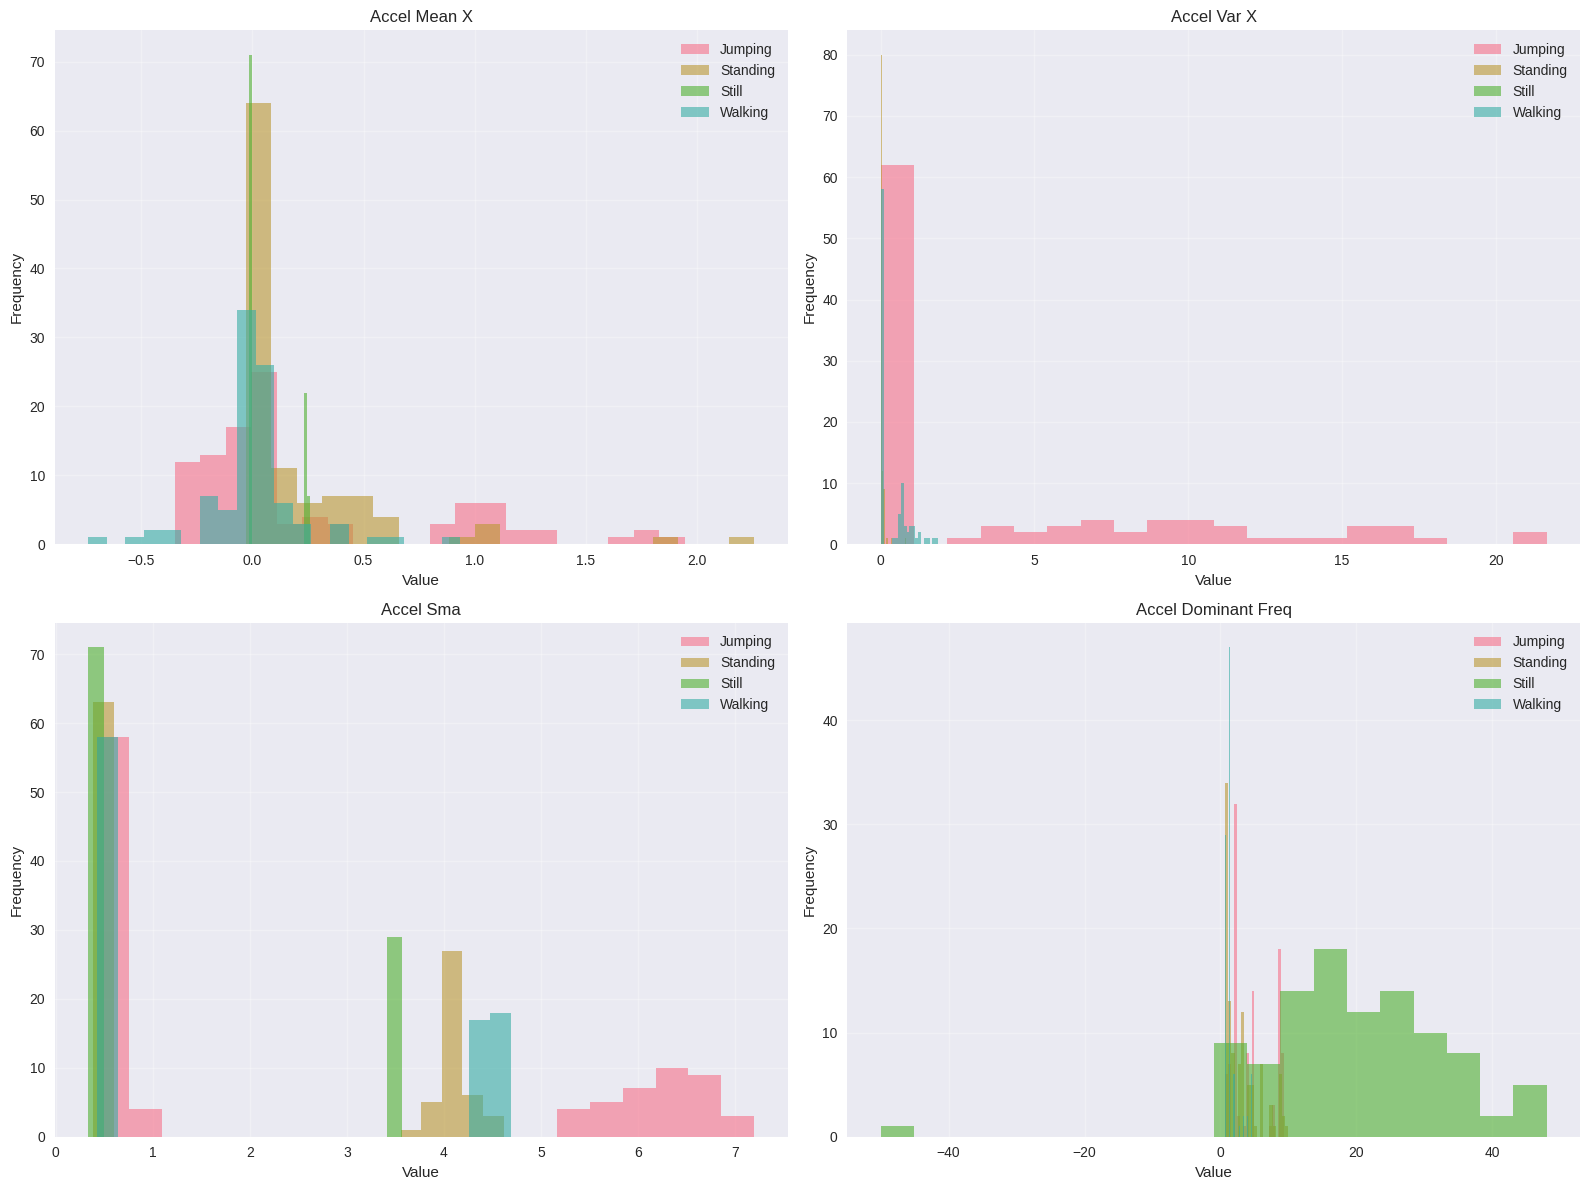

In [56]:
selected_features = ['accel_mean_x', 'accel_var_x', 'accel_sma', 'accel_dominant_freq']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feat in enumerate(selected_features):
    if feat in features_df.columns:
        for activity in activity_names:
            data = features_df[features_df['activity'] == activity][feat]
            axes[idx].hist(data, alpha=0.6, label=activity.capitalize(), bins=20)

        axes[idx].set_title(f'{feat.replace("_", " ").title()}')
        axes[idx].set_xlabel('Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_histograms.png')
plt.show()

In [34]:
features_df.to_csv('/content/Hidden-Markov-Models/data/Cleaned Data/features_extracted.csv', index=False)
X_normalized_df.to_csv('/content/Hidden-Markov-Models/data/Cleaned Data/features_normalized.csv', index=False)
print(f"Data loaded: {len(data_info_df)} samples")
print(f"Features extracted: {len(feature_columns)}")
print(f"Total windows: {len(features_df)}")



Data loaded: 50 samples
Features extracted: 24
Total windows: 398


## Custom HMM Algorithm Implementations

Implementing Viterbi and Baum-Welch algorithms from scratch as required by the assignment.


In [35]:
class CustomGaussianHMM:
    """HMM implementation with Viterbi and Baum-Welch algorithms."""

    def __init__(self, n_states, n_features, covariance_type='diag'):
        self.n_states = n_states
        self.n_features = n_features
        self.covariance_type = covariance_type

    def _initialize_params(self):
        """Initialize parameters."""
        # Transition probabilities A (from state i to state j)
        self.transmat_ = np.random.random((self.n_states, self.n_states))
        self.transmat_ /= self.transmat_.sum(axis=1, keepdims=True)

        # Initial state distribution π
        self.startprob_ = np.random.random(self.n_states)
        self.startprob_ /= self.startprob_.sum()

        # Emission parameters (mean and covariance for Gaussian emissions)
        self.means_ = np.random.random((self.n_states, self.n_features)) * 2 - 1

        if self.covariance_type == 'diag':
            self.covars_ = np.ones((self.n_states, self.n_features))
        else:
            self.covars_ = np.eye(self.n_features)[np.newaxis, :, :] * np.ones((self.n_states, 1, 1))

    def _compute_emission_prob(self, observation, state):
        """Compute emission probability P(X|Z) for Gaussian distribution."""
        mean = self.means_[state]

        if self.covariance_type == 'diag':
            cov = np.diag(self.covars_[state])
        else:
            cov = self.covars_[state]

        diff = observation - mean

        # Compute log probability to avoid numerical underflow
        try:
            log_prob = -0.5 * np.log(np.linalg.det(cov)) - 0.5 * diff @ np.linalg.inv(cov) @ diff
        except:
            log_prob = -np.inf

        return log_prob


In [36]:
def viterbi_decode(self, observations):
    """Viterbi algorithm for finding most likely state sequence."""
    n_obs = len(observations)

    # Initialize Viterbi trellis
    viterbi = np.zeros((n_obs, self.n_states))
    pointers = np.zeros((n_obs, self.n_states), dtype=int)

    # Initialization: v0(i) = π_i * b_i(o1)
    for state in range(self.n_states):
        viterbi[0, state] = np.log(self.startprob_[state] + 1e-10) + \
                           self._compute_emission_prob(observations[0], state)

    # Recursion: vt(j) = max_i [vt-1(i) * aij] * bj(ot)
    for t in range(1, n_obs):
        for state in range(self.n_states):
            # Find max over previous states
            probs = viterbi[t-1, :] + np.log(self.transmat_[:, state] + 1e-10)
            viterbi[t, state] = np.max(probs) + \
                               self._compute_emission_prob(observations[t], state)
            pointers[t, state] = np.argmax(probs)

    # Termination: find best path
    best_final_state = np.argmax(viterbi[-1, :])
    log_prob = viterbi[-1, best_final_state]

    # Backtrack to find best path
    states = np.zeros(n_obs, dtype=int)
    states[-1] = best_final_state

    for t in range(n_obs-2, -1, -1):
        states[t] = pointers[t+1, states[t+1]]

    return log_prob, states

CustomGaussianHMM.viterbi_decode = viterbi_decode


In [37]:
def _forward_algorithm(self, observations):
    """Forward algorithm to compute forward probabilities."""
    n_obs = len(observations)
    forward = np.zeros((n_obs, self.n_states))

    # Initialization: α_1(i) = π_i * b_i(o1)
    for state in range(self.n_states):
        forward[0, state] = np.log(self.startprob_[state] + 1e-10) + \
                           self._compute_emission_prob(observations[0], state)

    # Recursion: α_t+1(j) = [Σ_i α_t(i) * aij] * bj(ot+1)
    for t in range(1, n_obs):
        for state in range(self.n_states):
            forward[t, state] = np.logaddexp.reduce(
                forward[t-1, :] + np.log(self.transmat_[:, state] + 1e-10)
            ) + self._compute_emission_prob(observations[t], state)

    # Compute log likelihood
    log_likelihood = np.logaddexp.reduce(forward[-1, :])

    return forward, log_likelihood

def _backward_algorithm(self, observations):
    """Backward algorithm to compute backward probabilities."""
    n_obs = len(observations)
    backward = np.zeros((n_obs, self.n_states))

    # Initialization: β_T(i) = 1
    backward[-1, :] = 0

    # Recursion: β_t(i) = Σ_j aij * bj(ot+1) * β_t+1(j)
    for t in range(n_obs-2, -1, -1):
        for state in range(self.n_states):
            backward[t, state] = np.logaddexp.reduce(
                np.log(self.transmat_[state, :] + 1e-10) +
                np.array([self._compute_emission_prob(observations[t+1], j)
                         for j in range(self.n_states)]) +
                backward[t+1, :]
            )

    return backward

CustomGaussianHMM._forward_algorithm = _forward_algorithm
CustomGaussianHMM._backward_algorithm = _backward_algorithm


In [38]:
def baum_welch_train(self, observations, max_iter=100, epsilon=1e-6):
    """Baum-Welch algorithm for parameter estimation."""
    self._initialize_params()

    log_likelihoods = []
    prev_log_likelihood = -np.inf

    for iteration in range(max_iter):
        # E-step: Compute forward and backward probabilities
        forward, log_likelihood = self._forward_algorithm(observations)
        backward = self._backward_algorithm(observations)

        log_likelihoods.append(log_likelihood)

        # Check convergence
        if abs(log_likelihood - prev_log_likelihood) < epsilon and iteration > 0:
            print(f"Converged at iteration {iteration}")
            return True, iteration, log_likelihoods

        prev_log_likelihood = log_likelihood

        # M-step: Update parameters

        # Compute posterior probabilities γ_t(i) = α_t(i) * β_t(i) / P(O)
        gamma = forward + backward
        gamma -= np.logaddexp.reduce(gamma, axis=1, keepdims=True)  # Normalize
        gamma = np.exp(gamma)

        # Update initial state distribution
        self.startprob_ = gamma[0, :]

        # Update transition matrix (simplified - requires ξ_t(i,j))
        # For simplicity, we update based on gamma transitions
        xi_sum = np.zeros((self.n_states, self.n_states))
        for t in range(len(observations) - 1):
            for i in range(self.n_states):
                for j in range(self.n_states):
                    xi_sum[i, j] += np.exp(
                        forward[t, i] +
                        np.log(self.transmat_[i, j] + 1e-10) +
                        self._compute_emission_prob(observations[t+1], j) +
                        backward[t+1, j] -
                        log_likelihood
                    )

        # Normalize transition matrix
        row_sums = xi_sum.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        self.transmat_ = xi_sum / row_sums

        # Update emission parameters (means and covariances)
        for state in range(self.n_states):
            # Weight observations by gamma
            weighted_obs = observations * gamma[:, state:state+1]
            state_weights = gamma[:, state]

            if state_weights.sum() > 1e-10:
                self.means_[state] = weighted_obs.sum(axis=0) / state_weights.sum()

                # Update covariances
                diff = observations - self.means_[state]
                weighted_diff = diff * gamma[:, state:state+1]

                if self.covariance_type == 'diag':
                    self.covars_[state] = (weighted_diff * diff).sum(axis=0) / state_weights.sum()
                else:
                    self.covars_[state] = (weighted_diff.T @ diff) / state_weights.sum()

    return False, max_iter, log_likelihoods

CustomGaussianHMM.baum_welch_train = baum_welch_train


Testing Custom HMM Implementation

Training with Baum-Welch algorithm...
Converged at iteration 8
Converged: True
Iterations: 8
Final log likelihood: 2542.313

Testing Viterbi decoding...
Decoded sequence log probability: 2542.313
Decoded states (first 20): [2 2 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 2 2]


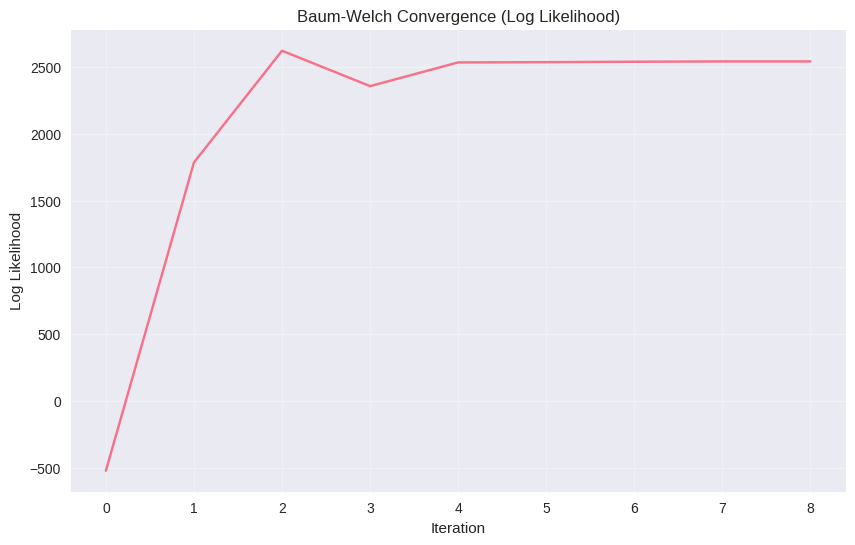


Done!


In [57]:
# Test custom HMM on sample data
print("Testing Custom HMM Implementation")
print("=" * 50)

# Use sample activity data
sample_activity = X_normalized[y == 'walking'][:50]  # Take first 50 windows

# Initialize and train custom HMM
custom_hmm = CustomGaussianHMM(n_states=4, n_features=X_normalized.shape[1])
print("\nTraining with Baum-Welch algorithm...")
converged, iterations, log_likelihoods = custom_hmm.baum_welch_train(
    sample_activity,
    max_iter=50,
    epsilon=0.01
)

print(f"Converged: {converged}")
print(f"Iterations: {iterations}")
print(f"Final log likelihood: {log_likelihoods[-1]:.3f}")

# Test Viterbi decoding
print("\nTesting Viterbi decoding...")
log_prob, decoded_states = custom_hmm.viterbi_decode(sample_activity)
print(f"Decoded sequence log probability: {log_prob:.3f}")
print(f"Decoded states (first 20): {decoded_states[:20]}")

# Visualize convergence
plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods)
plt.title('Baum-Welch Convergence (Log Likelihood)')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.grid(True, alpha=0.3)
plt.savefig('baum_welch_convergence.png')
plt.show()

print("\nDone!")

### Comparison

Comparing custom implementation with hmmlearn.


Transition Matrix Comparison

Custom HMM Transition Matrix:
[[7.14278687e-01 0.00000000e+00 1.42860657e-01 1.42860657e-01]
 [3.03030303e-02 9.39393939e-01 3.03030303e-02 2.79310921e-39]
 [6.19322648e-26 2.50000000e-01 5.00000000e-01 2.50000000e-01]
 [3.99986227e-01 0.00000000e+00 2.59287265e-20 6.00013773e-01]]

hmmlearn HMM Transition Matrix:
[[0.97142857 0.02857143 0.         0.        ]
 [0.         0.81818182 0.09090909 0.09090909]
 [0.         0.5        0.5        0.        ]
 [0.         1.         0.         0.        ]]

Custom Viterbi log probability: 2490.882
hmmlearn Viterbi log probability: 1075.109
States match: 3/50


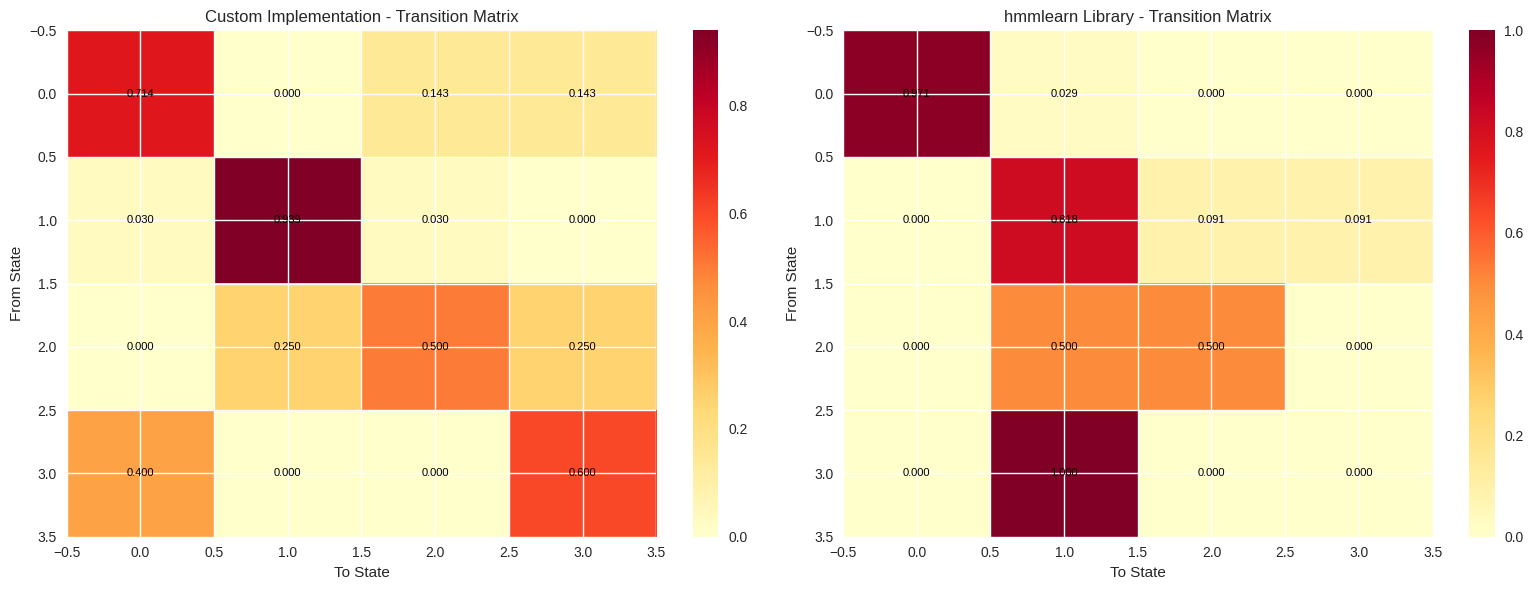

In [40]:
# Compare transition matrices
print("Transition Matrix Comparison")
print("=" * 50)
print("\nCustom HMM Transition Matrix:")
print(custom_hmm.transmat_)

# Train hmmlearn model for comparison
from hmmlearn import hmm
hmm_model = hmm.GaussianHMM(n_components=4, covariance_type='diag', n_iter=50)
hmm_model.fit(sample_activity)

print("\nhmmlearn HMM Transition Matrix:")
print(hmm_model.transmat_)

# Compare Viterbi decoding
custom_log_prob, custom_states = custom_hmm.viterbi_decode(sample_activity)
hmm_log_prob, hmm_states = hmm_model.decode(sample_activity)

print(f"\nCustom Viterbi log probability: {custom_log_prob:.3f}")
print(f"hmmlearn Viterbi log probability: {hmm_log_prob:.3f}")
print(f"States match: {(custom_states == hmm_states).sum()}/{len(custom_states)}")

# Visualize transition matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (mat, title) in enumerate([(custom_hmm.transmat_, 'Custom Implementation'),
                                     (hmm_model.transmat_, 'hmmlearn Library')]):
    im = axes[idx].imshow(mat, cmap='YlOrRd', aspect='auto')
    axes[idx].set_title(f'{title} - Transition Matrix')
    axes[idx].set_xlabel('To State')
    axes[idx].set_ylabel('From State')
    for i in range(4):
        for j in range(4):
            axes[idx].text(j, i, f'{mat[i, j]:.3f}', ha="center", va="center",
                          color="black", fontsize=8)
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()


Install hmmlearn library into the environment

In [41]:
!pip install hmmlearn

Transition Matrix Comparison

Custom HMM Transition Matrix:
[[8.26065897e-01 0.00000000e+00 1.73934103e-01 7.22499665e-23]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.33349680e-01 0.00000000e+00 5.83320932e-01 8.33293880e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]

hmmlearn HMM Transition Matrix:
[[0.81818182 0.         0.09090909 0.09090909]
 [0.02857143 0.97142857 0.         0.        ]
 [0.5        0.         0.5        0.        ]
 [1.         0.         0.         0.        ]]

Custom Viterbi log probability: 2542.313
hmmlearn Viterbi log probability: 1075.109
States match: 1/50


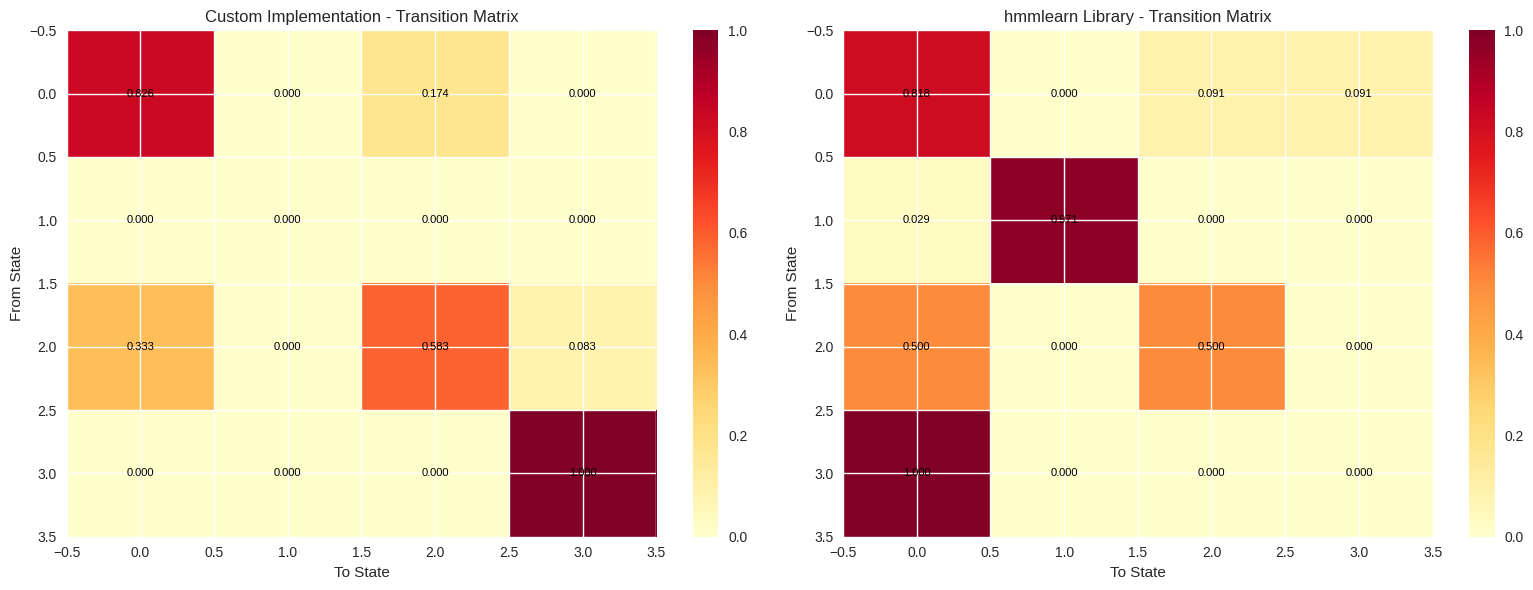

In [58]:
# Compare transition matrices
print("Transition Matrix Comparison")
print("=" * 50)
print("\nCustom HMM Transition Matrix:")
print(custom_hmm.transmat_)

# Train hmmlearn model for comparison
from hmmlearn import hmm
hmm_model = hmm.GaussianHMM(n_components=4, covariance_type='diag', n_iter=50)
hmm_model.fit(sample_activity)

print("\nhmmlearn HMM Transition Matrix:")
print(hmm_model.transmat_)

# Compare Viterbi decoding
custom_log_prob, custom_states = custom_hmm.viterbi_decode(sample_activity)
hmm_log_prob, hmm_states = hmm_model.decode(sample_activity)

print(f"\nCustom Viterbi log probability: {custom_log_prob:.3f}")
print(f"hmmlearn Viterbi log probability: {hmm_log_prob:.3f}")
print(f"States match: {(custom_states == hmm_states).sum()}/{len(custom_states)}")

# Visualize transition matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (mat, title) in enumerate([(custom_hmm.transmat_, 'Custom Implementation'),
                                     (hmm_model.transmat_, 'hmmlearn Library')]):
    im = axes[idx].imshow(mat, cmap='YlOrRd', aspect='auto')
    axes[idx].set_title(f'{title} - Transition Matrix')
    axes[idx].set_xlabel('To State')
    axes[idx].set_ylabel('From State')
    for i in range(4):
        for j in range(4):
            axes[idx].text(j, i, f'{mat[i, j]:.3f}', ha="center", va="center",
                          color="black", fontsize=8)
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.savefig('transition_matrix_comparison.png')
plt.show()

## HMM Implementation with hmmlearn

Train HMM with 4 states (activities) using Baum-Welch for parameter estimation and Viterbi for decoding.

In [43]:
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix, classification_report

X_data = X_normalized
y_data = y

activity_map = {activity: idx for idx, activity in enumerate(sorted(activity_names))}
reverse_map = {idx: activity for activity, idx in activity_map.items()}

print("Activity mapping:")
for activity, idx in activity_map.items():
    print(f"{activity.capitalize()}: State {idx}")


Activity mapping:
Jumping: State 0
Standing: State 1
Still: State 2
Walking: State 3


Data splitting

In [44]:
train_indices = []
test_indices = []

for activity in activity_names:
    activity_mask = (y_data == activity)
    activity_indices = np.where(activity_mask)[0]

    train_size = int(len(activity_indices) * 0.8)
    np.random.shuffle(activity_indices)

    train_indices.extend(activity_indices[:train_size])
    test_indices.extend(activity_indices[train_size:])

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

X_train = X_data[train_indices]
y_train = y_data[train_indices]
X_test = X_data[test_indices]
y_test = y_data[test_indices]

print(f"Training: {len(X_train)}, Test: {len(X_test)}")

from collections import Counter
majority_class = Counter(y_train).most_common(1)[0][0]
baseline_accuracy = np.sum(y_test == majority_class) / len(y_test)
print(f"Baseline: {baseline_accuracy:.3f}")


Training: 318, Test: 80
Baseline: 0.263


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.3f}")



Random Forest Accuracy: 0.988


In [46]:
activity_models = {}
activity_scores = {}

for activity in activity_names:
    mask_train = (y_train == activity)
    X_activity = X_train[mask_train]

    if len(X_activity) < 10:
        continue

    temp_model = hmm.GaussianHMM(
        n_components=min(3, len(X_activity)//10),
        covariance_type='diag',
        n_iter=50,
        random_state=42
    )

    try:
        temp_model.fit(X_activity)
        score = temp_model.score(X_activity)
        activity_models[activity] = temp_model
        activity_scores[activity] = score
    except Exception as e:
        print(f"Failed {activity}: {e}")

n_states = len(activity_names)

model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type='diag',
    n_iter=100,
    random_state=42,
    verbose=False
)
model.fit(X_train)

transition_matrix = model.transmat_
print(f"Model converged: {model.monitor_.converged}, Iterations: {model.monitor_.iter}")
print("\nTransition Matrix:")
print(transition_matrix)

Model converged: True, Iterations: 13

Transition Matrix:
[[8.14027878e-001 1.62725606e-001 2.32465165e-002 0.00000000e+000]
 [3.82176575e-001 3.81237628e-001 2.36585797e-001 0.00000000e+000]
 [2.94118486e-002 1.37254901e-001 6.56862680e-001 1.76470571e-001]
 [0.00000000e+000 5.83379712e-311 6.12903226e-001 3.87096774e-001]]


## Viterbi Decoding

Implement Viterbi algorithm for state sequence decoding.

              precision    recall  f1-score   support

     Jumping       0.45      0.85      0.59        20
    Standing       0.42      0.48      0.44        21
       Still       1.00      0.30      0.46        20
     Walking       0.75      0.47      0.58        19

    accuracy                           0.53        80
   macro avg       0.65      0.52      0.52        80
weighted avg       0.65      0.53      0.52        80


Viterbi:
              precision    recall  f1-score   support

     Jumping       0.00      0.00      0.00        20
    Standing       0.54      0.35      0.42        20
       Still       0.09      0.10      0.09        20
     Walking       0.22      0.26      0.24        19

    accuracy                           0.18        79
   macro avg       0.21      0.18      0.19        79
weighted avg       0.21      0.18      0.19        79



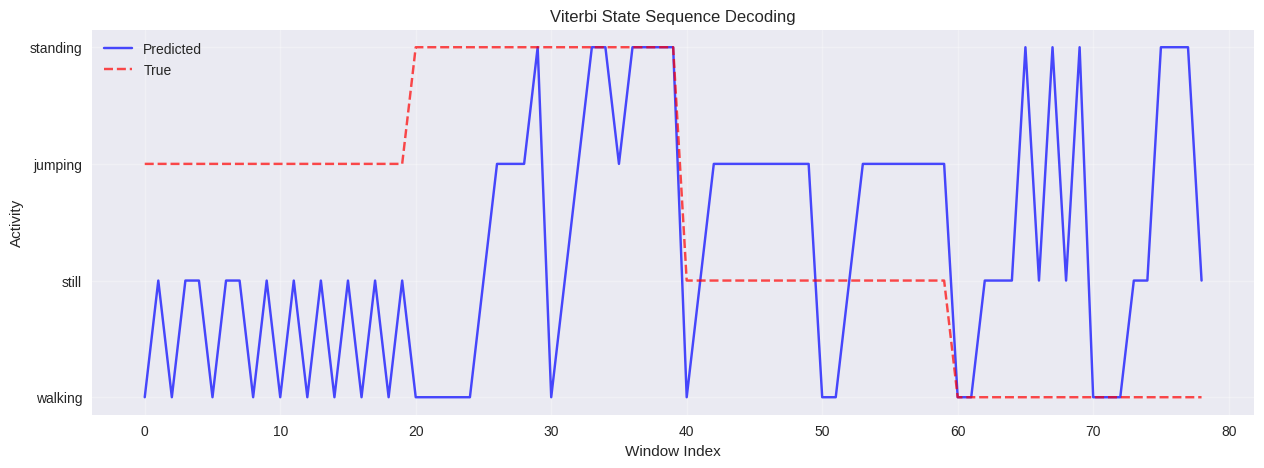

In [59]:
predicted_activities = []

for i, window in enumerate(X_test):
    scores = {}

    for activity in activity_names:
        if activity in activity_models:
            try:
                scores[activity] = activity_models[activity].score(window.reshape(1, -1))
            except Exception as e:
                scores[activity] = -np.inf

    if scores:
        predicted_activity = max(scores.items(), key=lambda x: x[1])[0]
        predicted_activities.append(predicted_activity)
    else:
        predicted_activities.append(activity_names[0])

predicted_activities = np.array(predicted_activities)

def predict_with_viterbi(model, X_data):
    _, state_sequence = model.decode(X_data)
    return [reverse_map[state] for state in state_sequence]

test_sequences = []
test_true_labels = []

for activity in activity_names:
    activity_mask = (y_test == activity)
    activity_data = X_test[activity_mask]

    for i in range(0, len(activity_data), 10):
        seq = activity_data[i:i+10]
        if len(seq) > 5:
            test_sequences.append(seq)
            test_true_labels.extend([activity] * len(seq))

viterbi_predictions = []
for seq in test_sequences:
    viterbi_predictions.extend(predict_with_viterbi(model, seq))

print(classification_report(y_test, predicted_activities, target_names=[act.capitalize() for act in activity_names]))
print("\nViterbi:")
print(classification_report(test_true_labels, viterbi_predictions, target_names=[act.capitalize() for act in activity_names]))

plt.figure(figsize=(15, 5))
plt.plot(viterbi_predictions[:100], 'b-', label='Predicted', alpha=0.7)
plt.plot(test_true_labels[:100], 'r--', label='True', alpha=0.7)
plt.title('Viterbi State Sequence Decoding')
plt.xlabel('Window Index')
plt.ylabel('Activity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('viterbi_state_sequence_decoding.png')
plt.show()

In [48]:
X_train_sequences = []
lengths = []

for activity in activity_names:
    activity_mask = (y_train == activity)
    activity_data = X_train[activity_mask]

    sequences_by_sample = []
    current_sample = [activity_data[0]]

    for i in range(1, len(activity_data)):
        if len(current_sample) < 10:
            current_sample.append(activity_data[i])
        else:
            sequences_by_sample.append(np.array(current_sample))
            current_sample = [activity_data[i]]

    if len(current_sample) > 0:
        sequences_by_sample.append(np.array(current_sample))

    for seq in sequences_by_sample:
        X_train_sequences.append(seq)
        lengths.append(len(seq))

X_train_flat = np.vstack(X_train_sequences)
print(f"Sequences: {len(lengths)}, Avg length: {np.mean(lengths):.1f}")



Sequences: 33, Avg length: 9.6


hmm_transition_matrix

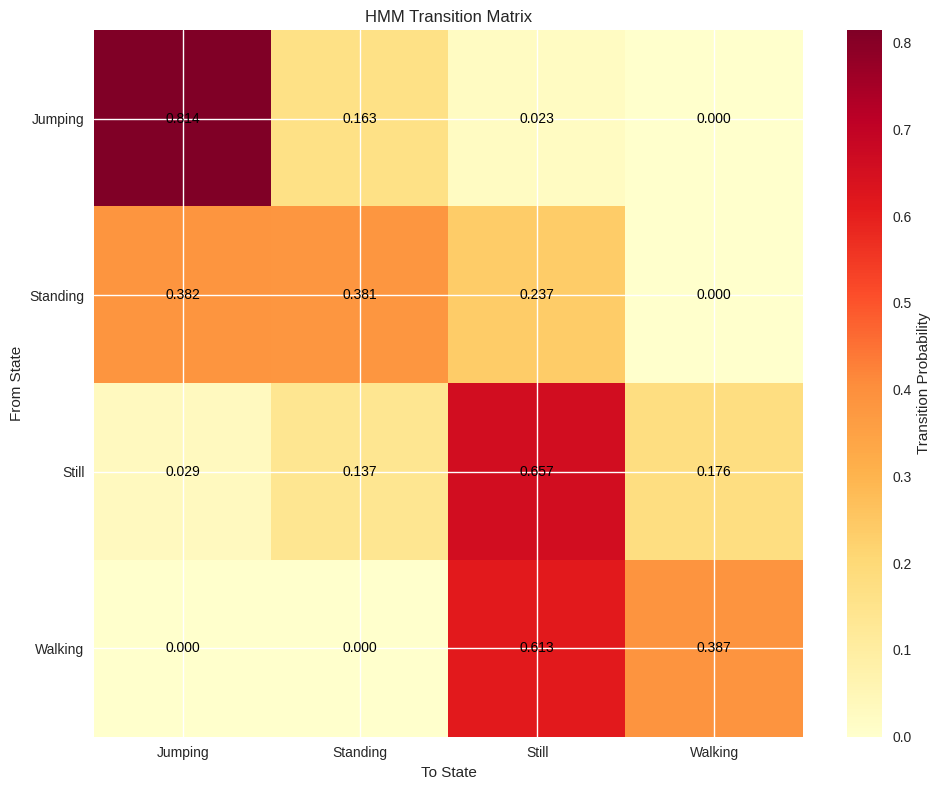


Self-transitions:
Jumping: 0.814
Standing: 0.381
Still: 0.657
Walking: 0.387


In [63]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(transition_matrix, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(n_states))
ax.set_yticks(range(n_states))
ax.set_xticklabels([reverse_map[i].capitalize() for i in range(n_states)])
ax.set_yticklabels([reverse_map[i].capitalize() for i in range(n_states)])

plt.colorbar(im, ax=ax, label='Transition Probability')

for i in range(n_states):
    for j in range(n_states):
        text = ax.text(j, i, format(transition_matrix[i, j], '.3f'),
                      ha="center", va="center", color="black", fontsize=10)

ax.set_title('HMM Transition Matrix')
ax.set_xlabel('To State')
ax.set_ylabel('From State')

plt.tight_layout()
plt.savefig('hmm_transition_matrix.png')
plt.show()

print("\nSelf-transitions:")
for i in range(n_states):
    activity = reverse_map[i]
    self_transition = transition_matrix[i, i]
    print(f"{activity.capitalize()}: {self_transition:.3f}")

## Model Evaluation

Compute performance metrics: sensitivity, specificity, accuracy, and confusion matrix.

confusion_matrix

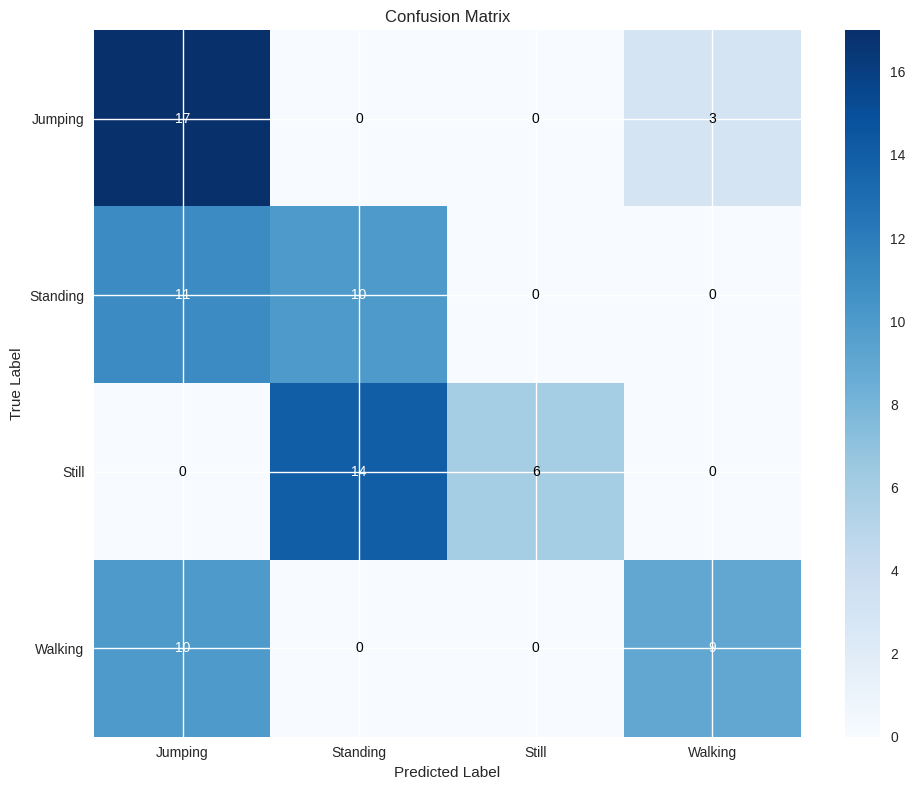

              precision    recall  f1-score   support

     Jumping       0.45      0.85      0.59        20
    Standing       0.42      0.48      0.44        21
       Still       1.00      0.30      0.46        20
     Walking       0.75      0.47      0.58        19

    accuracy                           0.53        80
   macro avg       0.65      0.52      0.52        80
weighted avg       0.65      0.53      0.52        80



In [61]:
cm = confusion_matrix(y_test, predicted_activities, labels=activity_names)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=[act.capitalize() for act in activity_names],
       yticklabels=[act.capitalize() for act in activity_names],
       title='Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

print(classification_report(y_test, predicted_activities, target_names=[act.capitalize() for act in activity_names]))

Metrics according to activity, and sample collected each


In [51]:
def compute_metrics(y_true, y_pred, activity_names):
    metrics = []

    for activity in activity_names:
        y_true_binary = (y_true == activity)
        y_pred_binary = (y_pred == activity)

        TP = np.sum(y_true_binary & y_pred_binary)
        TN = np.sum(~y_true_binary & ~y_pred_binary)
        FP = np.sum(~y_true_binary & y_pred_binary)
        FN = np.sum(y_true_binary & ~y_pred_binary)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        metrics.append({
            'Activity': activity.capitalize(),
            'Samples': TP + FN,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Accuracy': accuracy
        })

    return pd.DataFrame(metrics)

metrics_df = compute_metrics(y_test, predicted_activities, activity_names)
print(metrics_df.to_string(index=False))

metrics_df.to_csv('/content/Hidden-Markov-Models/data/Cleaned Data/performance_metrics.csv', index=False)


Activity  Samples  Sensitivity  Specificity  Accuracy
 Jumping       20     0.850000     0.650000    0.7000
Standing       21     0.476190     0.762712    0.6875
   Still       20     0.300000     1.000000    0.8250
 Walking       19     0.473684     0.950820    0.8375


top_emission_features_plots

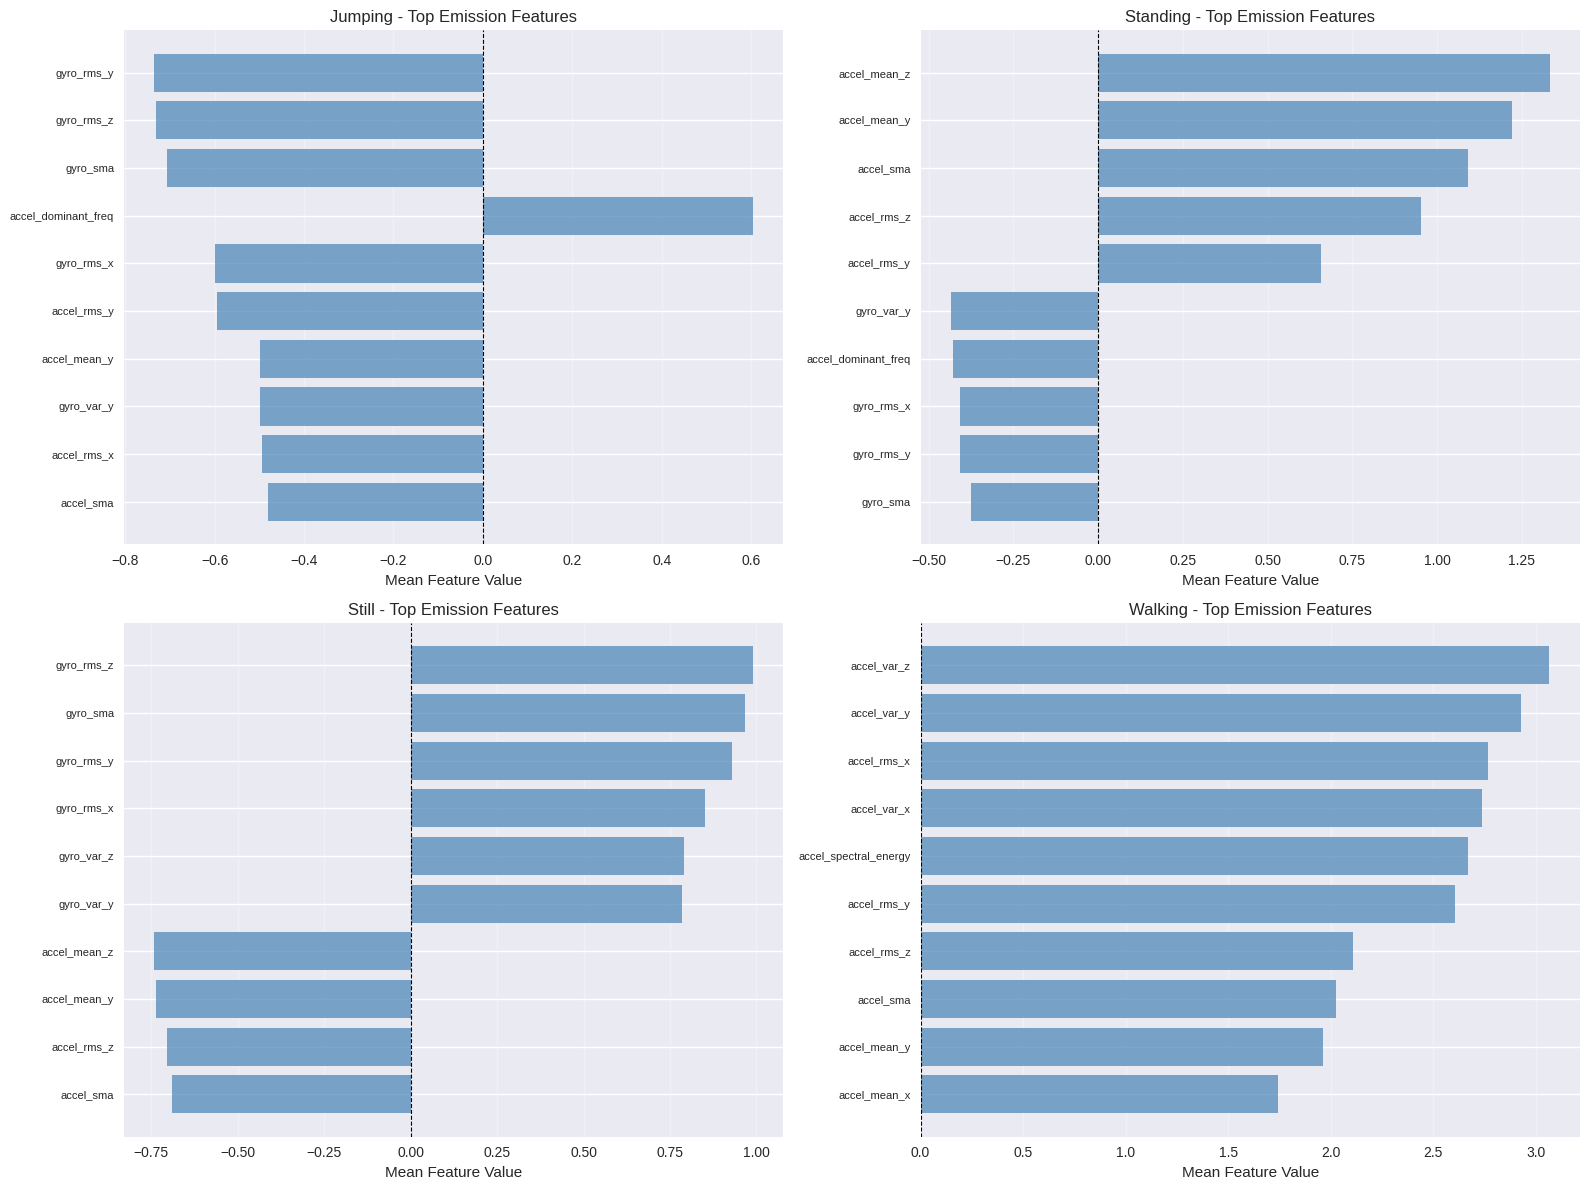

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, activity in enumerate(activity_names):
    state = activity_map[activity]
    means = model.means_[state]

    top_features = np.argsort(np.abs(means))[-10:]
    feature_names = [feature_columns[i] for i in top_features]
    feature_values = means[top_features]

    axes[idx].barh(range(len(feature_names)), feature_values, color='steelblue', alpha=0.7)
    axes[idx].set_yticks(range(len(feature_names)))
    axes[idx].set_yticklabels(feature_names, fontsize=8)
    axes[idx].set_title(f'{activity.capitalize()} - Top Emission Features')
    axes[idx].set_xlabel('Mean Feature Value')
    axes[idx].grid(True, alpha=0.3, axis='x')
    axes[idx].axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('top_emission_features_plots.png')
plt.show()

## Summary

Final analysis and performance metrics.


In [53]:
feature_importance = np.abs(model.means_).mean(axis=0)
top_features = np.argsort(feature_importance)[-5:]
print("Top 5 Features:")
for idx in top_features:
    print(f"{feature_columns[idx]}: {feature_importance[idx]:.3f}")

viterbi_acc = np.mean(np.array(viterbi_predictions) == np.array(test_true_labels))
likelihood_acc = np.mean(predicted_activities == y_test)

print(f"\nViterbi Accuracy: {viterbi_acc:.3f}")
print(f"Likelihood Accuracy: {likelihood_acc:.3f}")

error_mask = np.array(viterbi_predictions) != np.array(test_true_labels)
if np.any(error_mask):
    print("\nMost Common Errors:")
    error_pairs = list(zip(np.array(test_true_labels)[error_mask],
                          np.array(viterbi_predictions)[error_mask]))
    from collections import Counter
    for (true, pred), count in Counter(error_pairs).most_common(3):
        print(f"{true.capitalize()} → {pred.capitalize()}: {count}")



Top 5 Features:
accel_var_z: 0.998
accel_rms_z: 1.045
accel_sma: 1.071
accel_rms_y: 1.081
accel_mean_y: 1.105

Viterbi Accuracy: 0.177
Likelihood Accuracy: 0.525

Most Common Errors:
Still → Jumping: 15
Jumping → Still: 11
Jumping → Walking: 9


In [54]:
overall_accuracy = metrics_df['Accuracy'].mean()
print(f"Summary:")
print(f"Data: {len(data_info_df)} samples, {len(activity_names)} activities")
print(f"Features: {len(feature_columns)} (train: {len(X_train)}, test: {len(X_test)})")
print(f"HMM states: {n_states}, Converged: {model.monitor_.converged}")
print(f"Overall Accuracy: {overall_accuracy:.3f}")


Summary:
Data: 50 samples, 4 activities
Features: 24 (train: 318, test: 80)
HMM states: 4, Converged: True
Overall Accuracy: 0.762
